In [78]:
import matplotlib.pyplot as plt
import random
import torch
import tqdm

In [188]:
INPUT_FILE = "input.txt"
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
BATCH_SIZE = 64
CONTEXT_SIZE = 3
EMBEDDING_DIM = 10
L1_N_NEURONS = 300
LEARNING_RATE = 0.1
N_EPOCHS = 5
LR_DECAY_FREQ = 2
LR_DECAY_FACTOR = 0.1

In [189]:
with open(INPUT_FILE) as f:
    words = f.read().splitlines()

print(f"read {len(words)} words from {INPUT_FILE}")

read 32033 words from input.txt


In [190]:
tokens = sorted(set("".join(words)))
tokens.extend(["."])
token_to_index = {token: index for index, token in enumerate(tokens)}
index_to_token = {index: token for index, token in enumerate(tokens)}
tokenized_words = [[token_to_index[token] for token in word] for word in words]

In [191]:
def make_dataset(tokenized_words):
    X, Y = [], []
    for tokenized_word in tokenized_words:
        context = [token_to_index["."]] * CONTEXT_SIZE
        for token in tokenized_word+[token_to_index["."]]:
            X.append(context)
            Y.append(token)
            context = context[1:] + [token]
    return torch.tensor(X), torch.tensor(Y)

In [192]:
random.shuffle(tokenized_words)
n_words = len(tokenized_words)
X_train, Y_train = make_dataset(tokenized_words[:int(TRAIN_RATIO*n_words)])
X_val, Y_val = make_dataset(tokenized_words[int(TRAIN_RATIO*n_words):int((TRAIN_RATIO+VAL_RATIO)*n_words)])
X_test, Y_test = make_dataset(tokenized_words[int((TRAIN_RATIO+VAL_RATIO)*n_words):])

In [193]:
embeddings = torch.randn((len(tokens), EMBEDDING_DIM), requires_grad=True)
w1 = torch.randn((CONTEXT_SIZE * EMBEDDING_DIM, L1_N_NEURONS), requires_grad=True)
b1 = torch.randn(L1_N_NEURONS, requires_grad=True)
w2 = torch.randn((L1_N_NEURONS, len(tokens)), requires_grad=True)
b2 = torch.randn(len(tokens), requires_grad=True)
parameters = [embeddings, w1, b1, w2, b2]
print(f"number of parameters: {sum(p.numel() for p in parameters)}")

number of parameters: 17697


In [194]:
n_optimizations = 0
log_every = 100
train_losses = [] # train log losses
val_losses = [] # val log losses

current_learning_rate = LEARNING_RATE
for i in tqdm.tqdm(range(N_EPOCHS)):

    # decay learning rate
    if i > 0 and i % LR_DECAY_FREQ == 0:
        current_learning_rate *= LR_DECAY_FACTOR

    # shuffle data
    shuffled_indices = torch.randperm(X_train.shape[0])
    X_train = X_train[shuffled_indices]
    Y_train = Y_train[shuffled_indices]

    for b in range(0, len(X_train), BATCH_SIZE):
        # forward pass
        layer1 = torch.tanh(embeddings[X_train[b:b+BATCH_SIZE]].view(-1, CONTEXT_SIZE * EMBEDDING_DIM) @ w1 + b1)
        layer2 = layer1 @ w2 + b2
        loss = torch.nn.functional.cross_entropy(layer2, Y_train[b:b+BATCH_SIZE])

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
        for p in parameters:
            p.data += -current_learning_rate * p.grad

        # log
        if  n_optimizations == 0 or n_optimizations % log_every == 0 or n_optimizations == len(X_train) // BATCH_SIZE - 1:
            layer1 = torch.tanh(embeddings[X_train].view(-1, CONTEXT_SIZE * EMBEDDING_DIM) @ w1 + b1)
            layer2 = layer1 @ w2 + b2
            train_losses.append(torch.nn.functional.cross_entropy(layer2, Y_train).log10().item())
            layer1 = torch.tanh(embeddings[X_val].view(-1, CONTEXT_SIZE * EMBEDDING_DIM) @ w1 + b1)
            layer2 = layer1 @ w2 + b2
            val_losses.append(torch.nn.functional.cross_entropy(layer2, Y_val).log10().item())
        n_optimizations += 1

    print(f"epoch {i+1}, train loss {10**train_losses[-1]:.3f}, val loss {10**val_losses[-1]:.3f} with learning rate {current_learning_rate:.3f}")

 20%|██        | 1/5 [00:06<00:26,  6.56s/it]

epoch 1, train loss 2.877, val loss 2.924 with learning rate 0.100


 40%|████      | 2/5 [00:12<00:17,  5.99s/it]

epoch 2, train loss 2.673, val loss 2.712 with learning rate 0.100


 60%|██████    | 3/5 [00:17<00:11,  5.71s/it]

epoch 3, train loss 2.367, val loss 2.402 with learning rate 0.010


 80%|████████  | 4/5 [00:21<00:05,  5.12s/it]

epoch 4, train loss 2.354, val loss 2.391 with learning rate 0.010


100%|██████████| 5/5 [00:28<00:00,  5.61s/it]

epoch 5, train loss 2.339, val loss 2.376 with learning rate 0.001


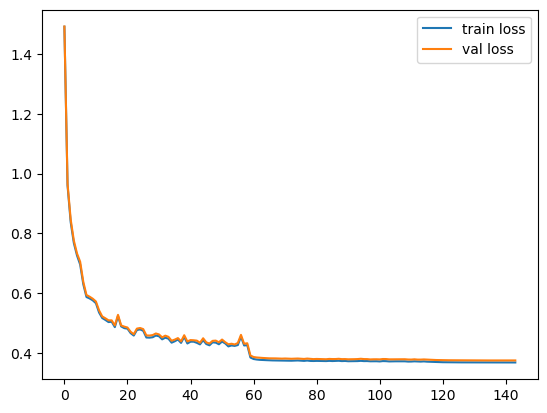

In [196]:
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend()
plt.show()

In [200]:
def infer_word():
    context = [token_to_index["."]] * CONTEXT_SIZE
    word = ""
    while True:
        layer1 = torch.tanh(embeddings[context].view(-1, CONTEXT_SIZE * EMBEDDING_DIM) @ w1 + b1)
        layer2 = layer1 @ w2 + b2
        probabilities = torch.nn.functional.softmax(layer2, dim=1)
        index = torch.multinomial(probabilities, num_samples=1)[0].item()
        if index == token_to_index["."]:
            break
        context = context[1:] + [index]
        word += index_to_token[index]
    return word

In [211]:
for i in range(20):
    word = infer_word()
    while word in words:
        word = infer_word()
    print(word)

giac
sah
rashns
dorylene
kayyn
iion
breelynneka
jakmitin
merrivalsllan
ritha
aiha
kosttuna
jekalis
abillania
cobilleliderryiah
auci
cieina
ery
diollyn
kirsh
